## NN Classification on previous datasets

In [1]:
# Useful imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import os

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.utils import class_weight
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# utility code

random_seed = 42

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages


In [2]:
# Utility function to plot learning curves and keep track of all results

# Call `print_results()` to see listing of all results logged so far


def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,{min_val_epoch + 1})

results = {}

In [3]:
def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}")

In [ ]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model, 
                   epochs        = 500,                   # Just needs to be bigger than early stop point
                   lr_schedule   = 0.001,                 # Adam default / 10 seems to work well for this dataset
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 64,                     # experiments confirmed this was optimal with other parameters at default
                   use_early_stopping = True,
                   patience      = 10,                                       
                   min_delta     = 0.0001,                 
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["f1_score", "accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )
    

    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),       # must use stratified validation set
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]
    
    # Find epoch of minimum validation loss and corresponding metrics
    val_losses = history.history['val_loss']
    min_val_epoch = int(np.argmin(val_losses))            # 0-based
    min_val_loss = float(val_losses[min_val_epoch])
    val_acc_at_min_loss = float(history.history['val_accuracy'][min_val_epoch])

    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    y_pred = model.predict(X_test
    )
    pred_labels = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_test, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: True Labels vs Predicted Labels')
    plt.xlabel("Predicted Clusters")
    plt.ylabel("True Labels")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    metrics = {
        "min_val_epoch": min_val_epoch + 1,   # 1-based for readability
        "min_val_loss": min_val_loss,
        "val_acc_at_min_loss": val_acc_at_min_loss,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy
    }

    if return_history:
        return history, metrics
    return metrics

In [5]:
def encoding(df_or_series, cat_cols: list = None, one_hot: bool = False):
    """
    Encodes categorical columns in a DataFrame or a single pandas Series.

    Args:
        df_or_series: DataFrame or Series to encode.
        cat_cols: List of columns to encode (only used if input is DataFrame).
        one_hot: If True, use one-hot encoding for DataFrame input.

    Returns:
        If input is DataFrame: (encoded DataFrame, mappings dict or list of new columns)
        If input is Series: (encoded Series, mapping dict)
    """
    if isinstance(df_or_series, pd.Series):
        uniques = df_or_series.dropna().unique().tolist()
        mapping = {cat: code for code, cat in enumerate(uniques)}
        encoded = df_or_series.map(mapping).astype("int64")
        return encoded
    
    elif isinstance(df_or_series, pd.DataFrame):
        if one_hot:
            if cat_cols is None:
                cat_cols = df_or_series.select_dtypes(include=['object', 'category']).columns.tolist()
            df_encoded = pd.get_dummies(df_or_series, columns=cat_cols, drop_first=True)
            return df_encoded
        else:
            df_encoded = df_or_series.copy()
            mappings = {}
            if cat_cols is None:
                cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
            for col in cat_cols:
                uniques = df_encoded[col].dropna().unique().tolist()
                mapping = {cat: code for code, cat in enumerate(uniques)}
                mappings[col] = mapping
                df_encoded[col] = df_encoded[col].map(mapping).astype("int64")
            return df_encoded
    
    else:
        raise ValueError("Input must be a pandas DataFrame or Series.")

In [6]:
def load_and_split_data(file_path: str, 
                        target_col: str = None, 
                        one_hot: bool = False, 
                        test_size: float = 0.2, 
                        random_state: int = 0, 
                        scaling: str = 'norm'
                        ):
    """
    Loads data, encodes categorical features, splits into train/test, and scales features.

    Args:
        file_path: Path to CSV file.
        target_col: Name of target column. If None, uses last column.
        test_size: Fraction for test split.
        random_state: Random seed.
        scaling: 'norm' (MinMax), 'reg' (Standard), or None.

    Returns:
        X_train, X_test, y_train, y_test, df, mappings
    """
    df = pd.read_csv(file_path)
    
    # Select target
    if target_col is None:
        target_col = df.columns[-1]
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Encode Categorical Features
    if one_hot is True:
        X_encoded = encoding(X, one_hot=True)
        if y.dtype == 'object' or y.dtype.name == 'category':
            y_encoded = encoding(y)
        else:
            y_encoded = y
    else:
        X_encoded = encoding(X)
        if y.dtype == 'object' or y.dtype.name == 'category':
            y_encoded = encoding(y)
        else:
            y_encoded = y
        
    # stratified 60/20/20 split (train/val/test)
    test_size = 0.20
    val_size = 0.20  # of the whole dataset

    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X_encoded, y_encoded, test_size=test_size, random_state=random_seed, stratify=y_encoded
    )
    val_size_rel = val_size / (1.0 - test_size)  # e.g., 0.20 / 0.80 = 0.25

    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=val_size_rel, random_state=random_seed, stratify=y_trainval
    )

    # Reset indices
    X_train = X_train.reset_index(drop=True)
    X_val = X_val.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_val = y_val.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    # Scaling
    if scaling == 'reg':
        scaler = StandardScaler()
    elif scaling == 'norm':
        scaler = MinMaxScaler()
    else:
        scaler = None

    if scaler is not None:
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    # quick sanity checks
    def show_counts(name, y_arr):
        c = Counter(y_arr)
        total = sum(c.values())
        print(f"{name}: total={total}, per-class={dict(c)}")

    print("shapes:", "X_train", X_train.shape, "X_val", X_val.shape, "X_test", X_test.shape)
    show_counts("train", y_train)
    show_counts("val  ", y_val)
    show_counts("test ", y_test)

    # you now have: X_train, y_train, X_val, y_val, X_test, y_test

    # Looks like integer encoded multi-class, let's check and define the global n_classes

    labels = np.unique(y_train)

    n_classes = len(labels)

    print("class labels:",labels)

    return X_train, X_val, X_test, y_train, y_val, y_test, df, n_classes


In [7]:
# Import data and split
X_train, X_val, X_test, y_train, y_val, y_test, df, n_classes = load_and_split_data(r"C:\Users\JT von Seggern\DS Masters Repos\799S-Data-Science-Capstone\data\carclaims_cleaned.csv", target_col='FraudFound', one_hot=True, scaling='reg')

shapes: X_train (9252, 123) X_val (3084, 123) X_test (3084, 123)
train: total=9252, per-class={0: 8698, 1: 554}
val  : total=3084, per-class={0: 2900, 1: 184}
test : total=3084, per-class={0: 2899, 1: 185}
class labels: [0 1]


In [8]:
# This function will build a multi-class classifier with dropout and L2 regularization.
# You must specify the number of input features, the number of classes, and a list of layer hyperparameters
# in the form  [ ...., (width, activation function, L2 lambda, dropout rate), .... ]

# Note that when adding dropout, this appears as a separate layer, but it has no parameters to be trained. 

def build_model(n_inputs,layer_list,n_classes):
    layers = [ Input(shape=(n_inputs,)) ]
    for (width,act,l2_lambda,dropout_rate) in layer_list:
        layers.append( Dense(width, activation=act, kernel_regularizer=regularizers.l2(l2_lambda)) )
        if dropout_rate > 0:
            layers.append( Dropout(dropout_rate) )
    layers.append( Dense(n_classes, activation='softmax') )
    return models.Sequential( layers )

In [9]:
build_model(X_train.shape[1], [ (64,'relu',0.0,0.0), (32,'relu',0.001,0.3)], n_classes).summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,082 (39.38 KB)

 Trainable params: 10,082 (39.38 KB)

 Non-trainable params: 0 (0.00 B)

### Activation Function testing


Activation Function: relu



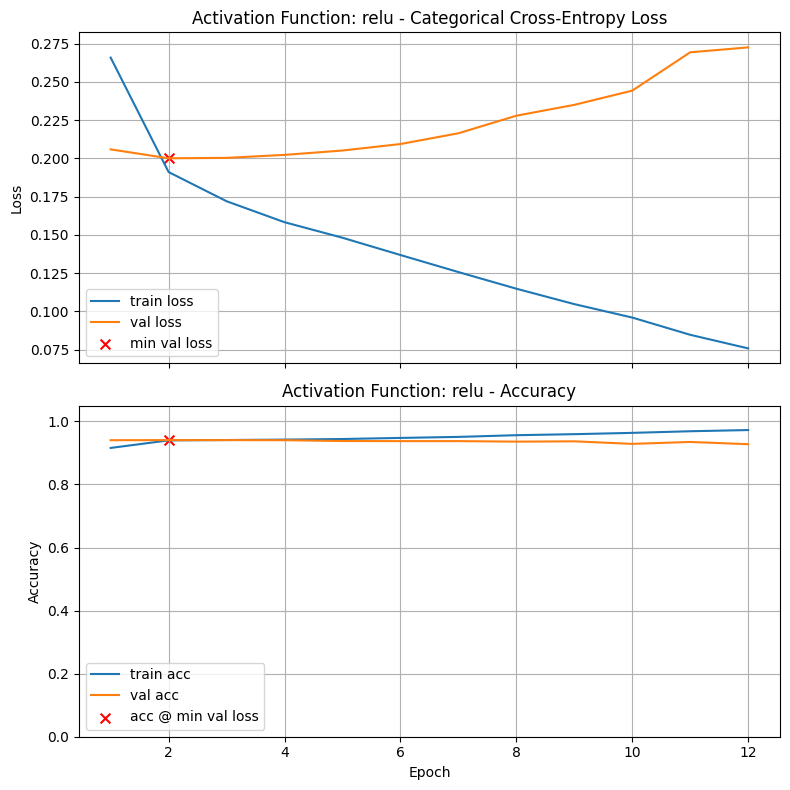

Final Training Loss:            0.0757
Final Training Accuracy:        0.9725
Final Validation Loss:          0.2725
Final Validation Accuracy:      0.9277
Minimum Validation Loss:        0.2000 (Epoch 2)
Validation Accuracy @ Min Loss: 0.9407
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step


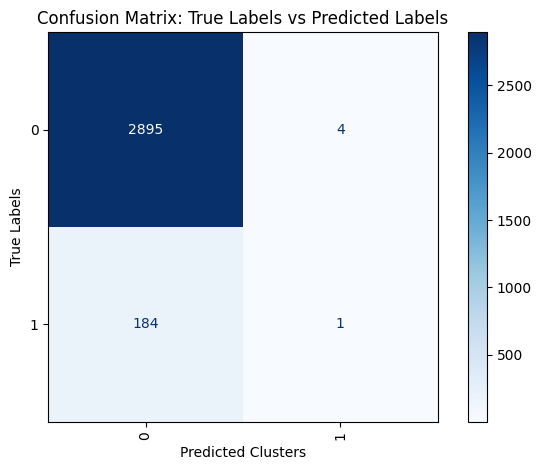


Test Loss: 0.1985
Test Accuracy: 0.9390

Validation-Test Gap (accuracy): 0.001621

Execution Time: 00:00:04

Activation Function: tanh



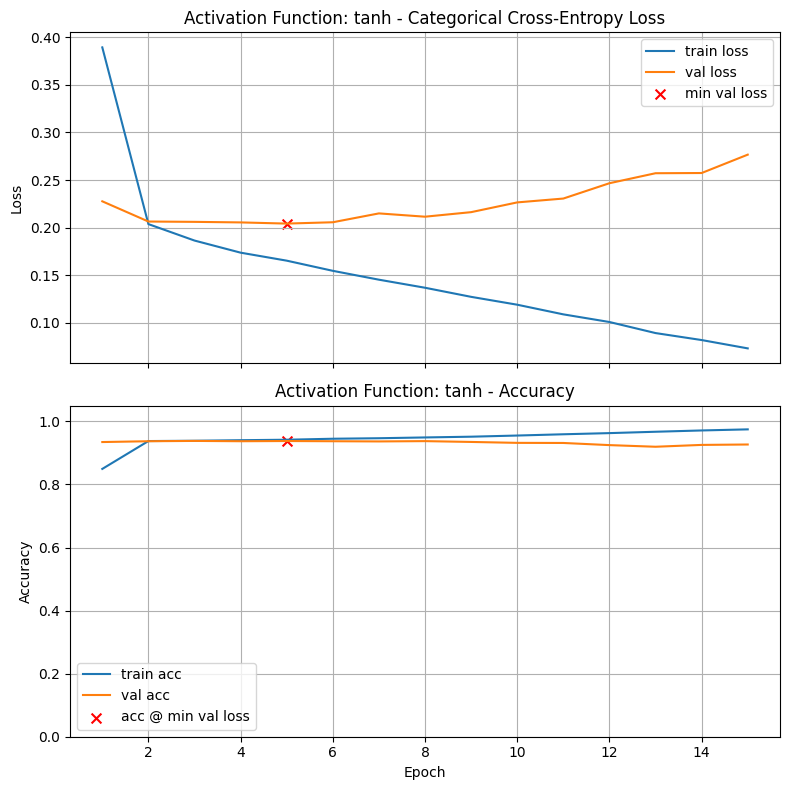

Final Training Loss:            0.0729
Final Training Accuracy:        0.9747
Final Validation Loss:          0.2767
Final Validation Accuracy:      0.9267
Minimum Validation Loss:        0.2042 (Epoch 5)
Validation Accuracy @ Min Loss: 0.9377
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


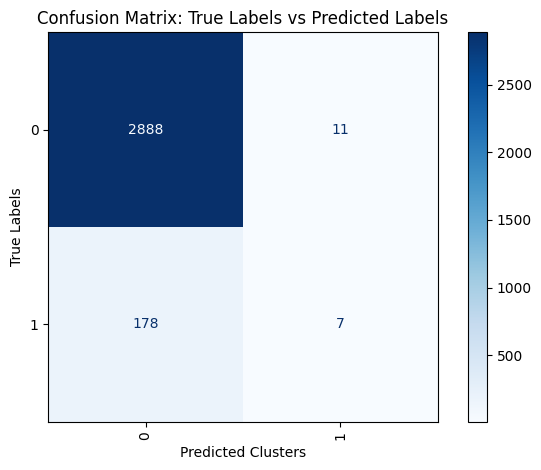


Test Loss: 0.1935
Test Accuracy: 0.9387

Validation-Test Gap (accuracy): 0.000973

Execution Time: 00:00:05

Activation Function: sigmoid



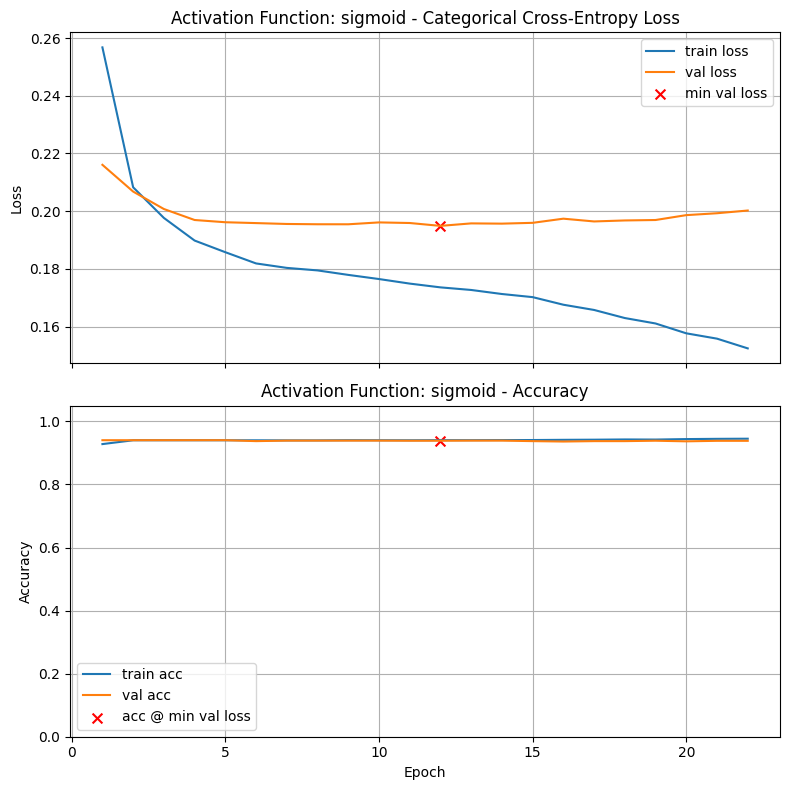

Final Training Loss:            0.1524
Final Training Accuracy:        0.9451
Final Validation Loss:          0.2002
Final Validation Accuracy:      0.9384
Minimum Validation Loss:        0.1949 (Epoch 12)
Validation Accuracy @ Min Loss: 0.9387
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step


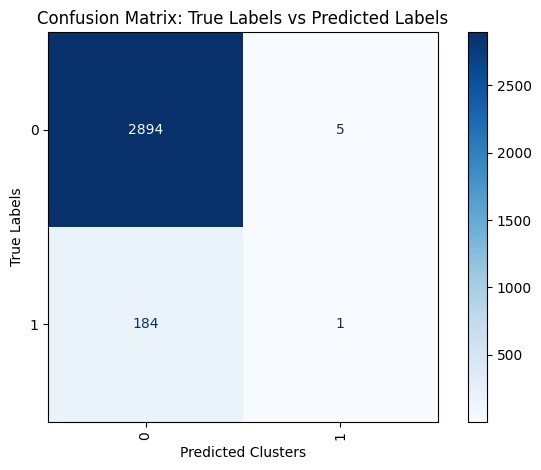


Test Loss: 0.1916
Test Accuracy: 0.9387

Validation-Test Gap (accuracy): 0.000000

Execution Time: 00:00:07


In [10]:
# Your code here. Add as many cells as you need.
activation = ['relu', 'tanh', 'sigmoid']

results_1 = pd.DataFrame(columns=['Activation Function', 'Best Val Accuracy', 'Min Val Loss'], index=[0,1,2])

for i, func in enumerate(activation):
    model = build_model(X_train.shape[1], [ (64, func, 0.0, 0.0), (32, func, 0.0, 0.0)], n_classes)
    history, metrics = train_and_test(model, title=f"Activation Function: {func}", verbose=0, return_history = True)
    results_1.loc[i] = [func, metrics['val_acc_at_min_loss'], metrics['min_val_loss']]

In [11]:
results_1

,Activation Function,Best Val Accuracy,Min Val Loss
0,relu,0.940661,0.200003
1,tanh,0.937743,0.204181
2,sigmoid,0.938716,0.194894


### Learning Rate Testing


Learning Rate: 0.001



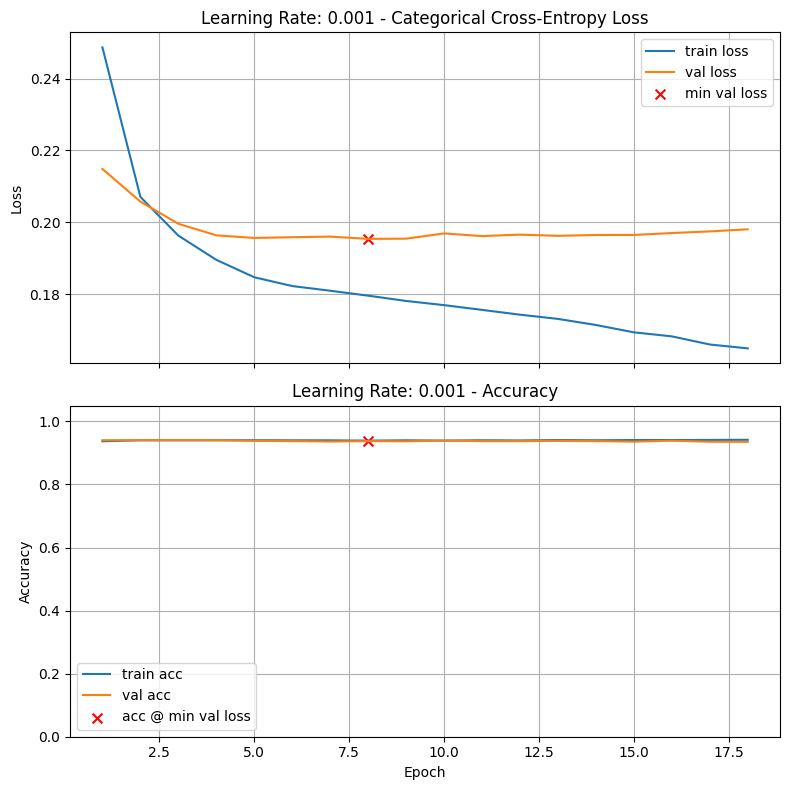

Final Training Loss:            0.1649
Final Training Accuracy:        0.9416
Final Validation Loss:          0.1980
Final Validation Accuracy:      0.9351
Minimum Validation Loss:        0.1954 (Epoch 8)
Validation Accuracy @ Min Loss: 0.9374
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step


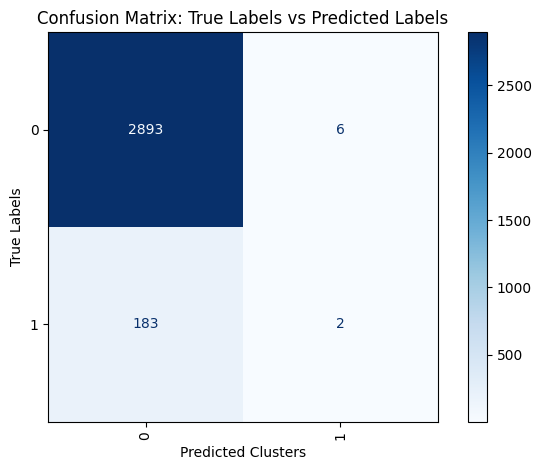


Test Loss: 0.1913
Test Accuracy: 0.9387

Validation-Test Gap (accuracy): 0.001297

Execution Time: 00:00:05

Learning Rate: 0.0005



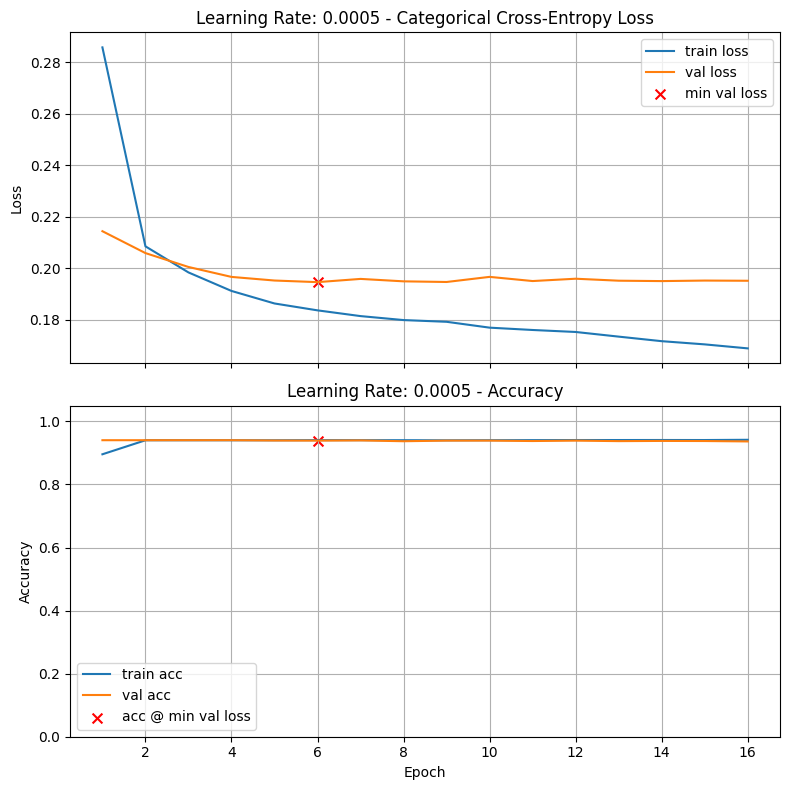

Final Training Loss:            0.1688
Final Training Accuracy:        0.9416
Final Validation Loss:          0.1951
Final Validation Accuracy:      0.9364
Minimum Validation Loss:        0.1946 (Epoch 6)
Validation Accuracy @ Min Loss: 0.9390
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step


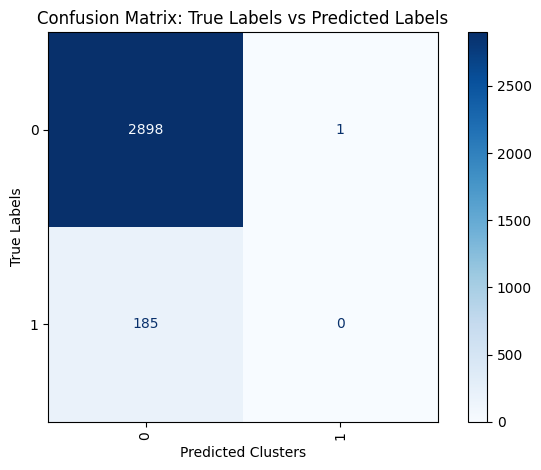


Test Loss: 0.1920
Test Accuracy: 0.9397

Validation-Test Gap (accuracy): 0.000649

Execution Time: 00:00:05

Learning Rate: 0.0001



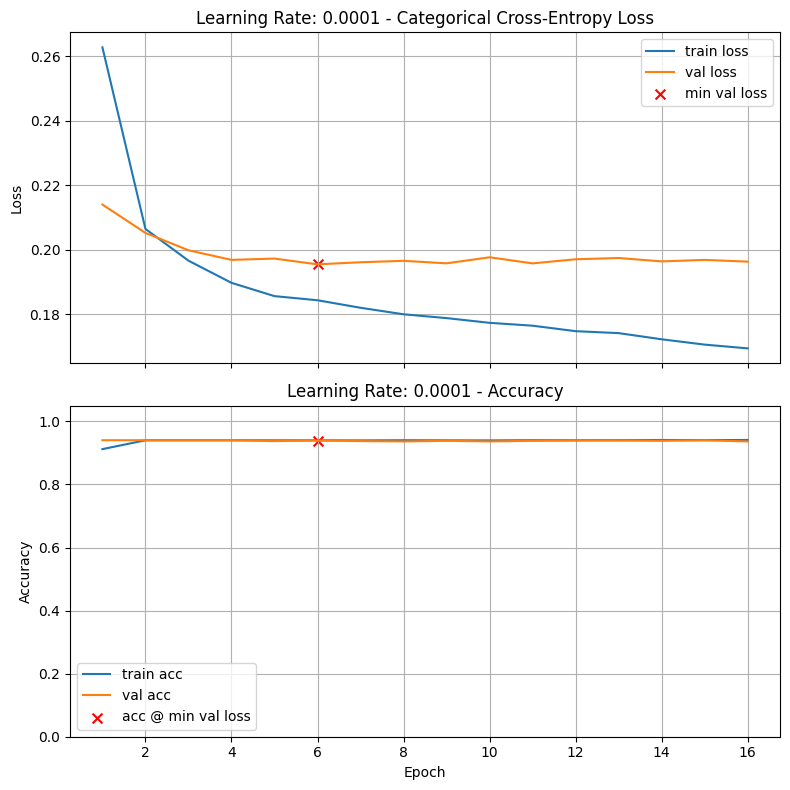

Final Training Loss:            0.1694
Final Training Accuracy:        0.9411
Final Validation Loss:          0.1963
Final Validation Accuracy:      0.9364
Minimum Validation Loss:        0.1954 (Epoch 6)
Validation Accuracy @ Min Loss: 0.9394
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step


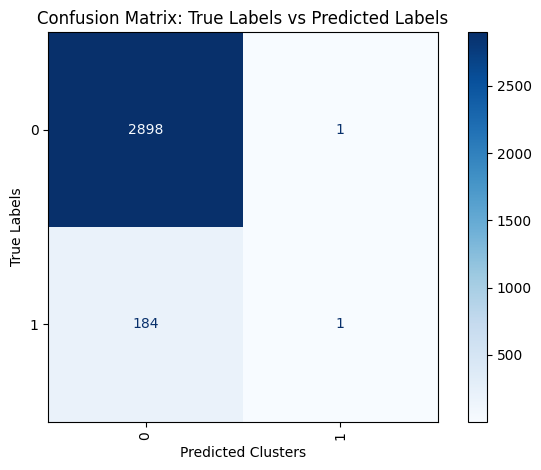


Test Loss: 0.1911
Test Accuracy: 0.9400

Validation-Test Gap (accuracy): 0.000649

Execution Time: 00:00:04

Learning Rate: 5e-05



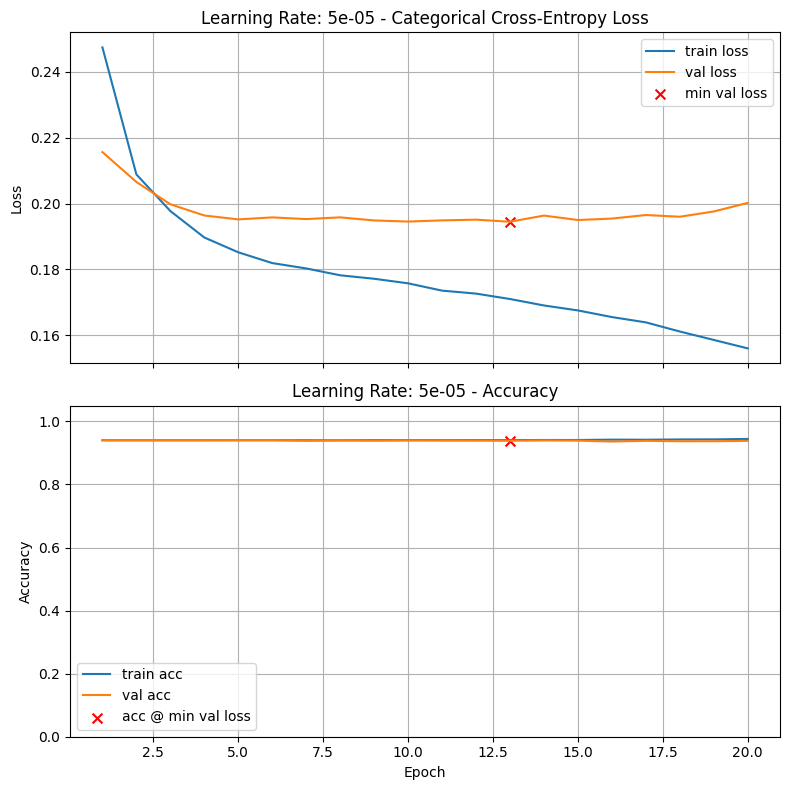

Final Training Loss:            0.1560
Final Training Accuracy:        0.9443
Final Validation Loss:          0.2002
Final Validation Accuracy:      0.9384
Minimum Validation Loss:        0.1945 (Epoch 13)
Validation Accuracy @ Min Loss: 0.9387
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step


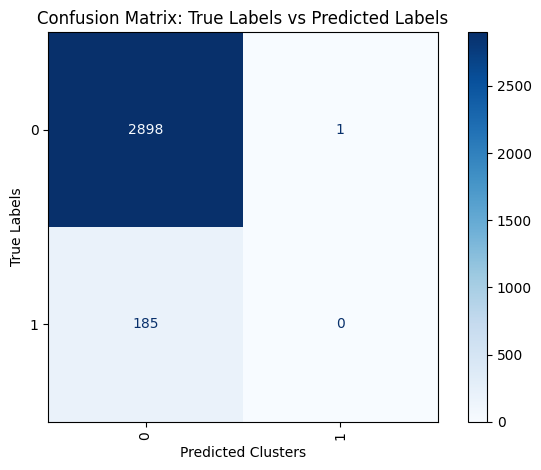


Test Loss: 0.1914
Test Accuracy: 0.9397

Validation-Test Gap (accuracy): 0.000000

Execution Time: 00:00:05

Learning Rate: 1e-05



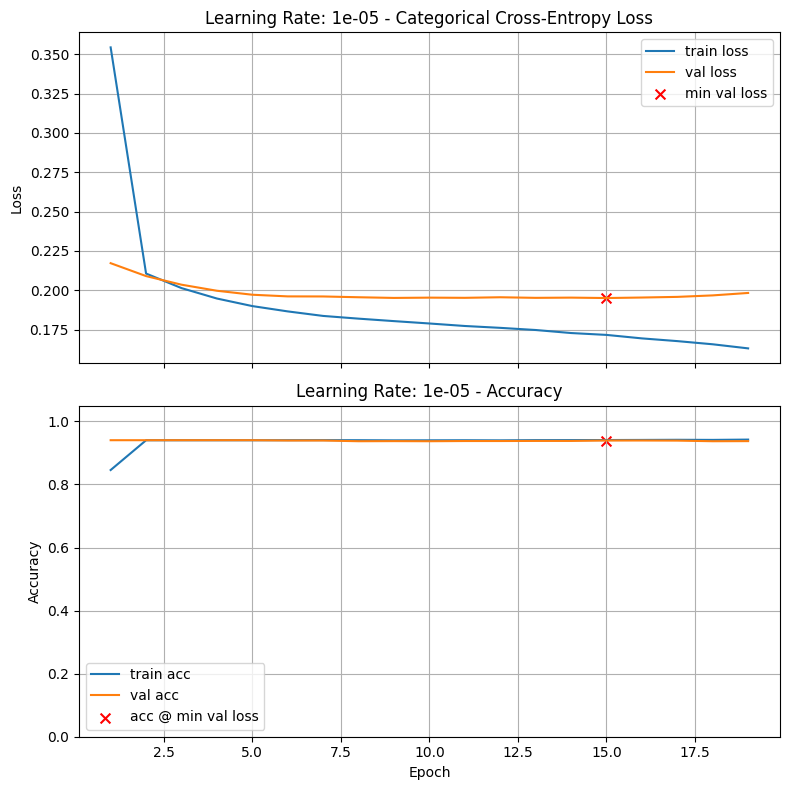

Final Training Loss:            0.1630
Final Training Accuracy:        0.9423
Final Validation Loss:          0.1983
Final Validation Accuracy:      0.9374
Minimum Validation Loss:        0.1950 (Epoch 15)
Validation Accuracy @ Min Loss: 0.9394
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step


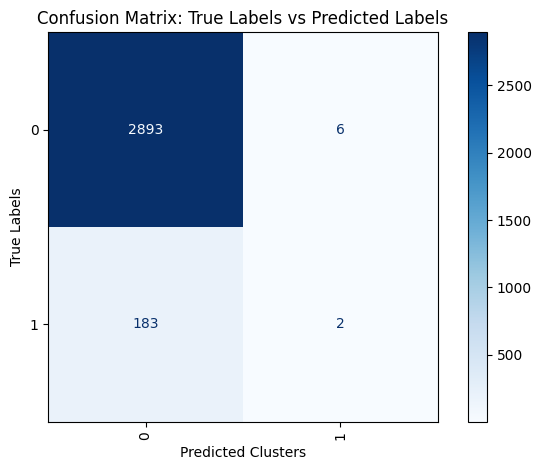


Test Loss: 0.1920
Test Accuracy: 0.9387

Validation-Test Gap (accuracy): 0.001297

Execution Time: 00:00:05


In [12]:
# Your code here. Add as many cells as you need.
af = 'sigmoid'
learning_rate = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]

results_2 = pd.DataFrame(columns=['Learning Rate', 'Best Val Accuracy', 'Min Val Loss'], index=[0,1,2,3,4])

for i, lr in enumerate(learning_rate):
    model = build_model(X_train.shape[1], [ (64, af, 0.0, 0.0), (32, af, 0.0, 0.0)], n_classes)
    history, metrics = train_and_test(model, title=f"Learning Rate: {lr}", verbose=0, return_history = True)
    results_2.loc[i] = [lr, metrics['val_acc_at_min_loss'], metrics['min_val_loss']]

In [13]:
results_2

,Learning Rate,Best Val Accuracy,Min Val Loss
0,0.001,0.937419,0.195372
1,0.0005,0.93904,0.194551
2,0.0001,0.939364,0.195425
3,0.00005,0.938716,0.19447
4,0.00001,0.939364,0.195041


### Dropout Testing


Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.3



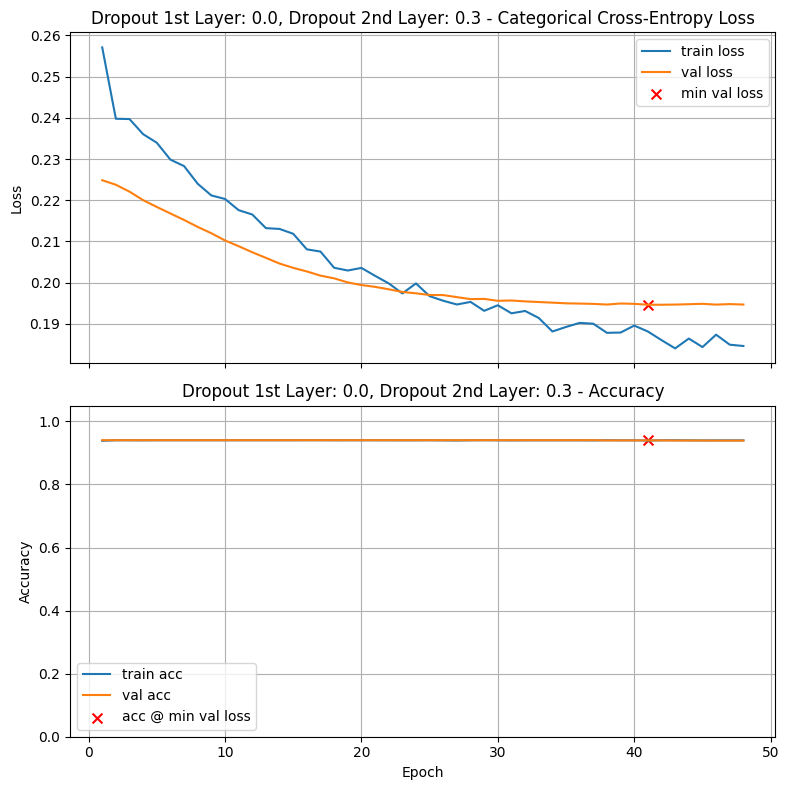

Final Training Loss:            0.1846
Final Training Accuracy:        0.9398
Final Validation Loss:          0.1947
Final Validation Accuracy:      0.9390
Minimum Validation Loss:        0.1946 (Epoch 41)
Validation Accuracy @ Min Loss: 0.9397
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step


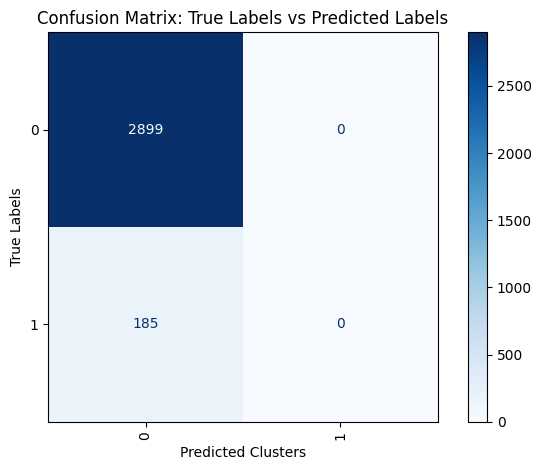


Test Loss: 0.1914
Test Accuracy: 0.9400

Validation-Test Gap (accuracy): 0.000324

Execution Time: 00:00:12

Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.4



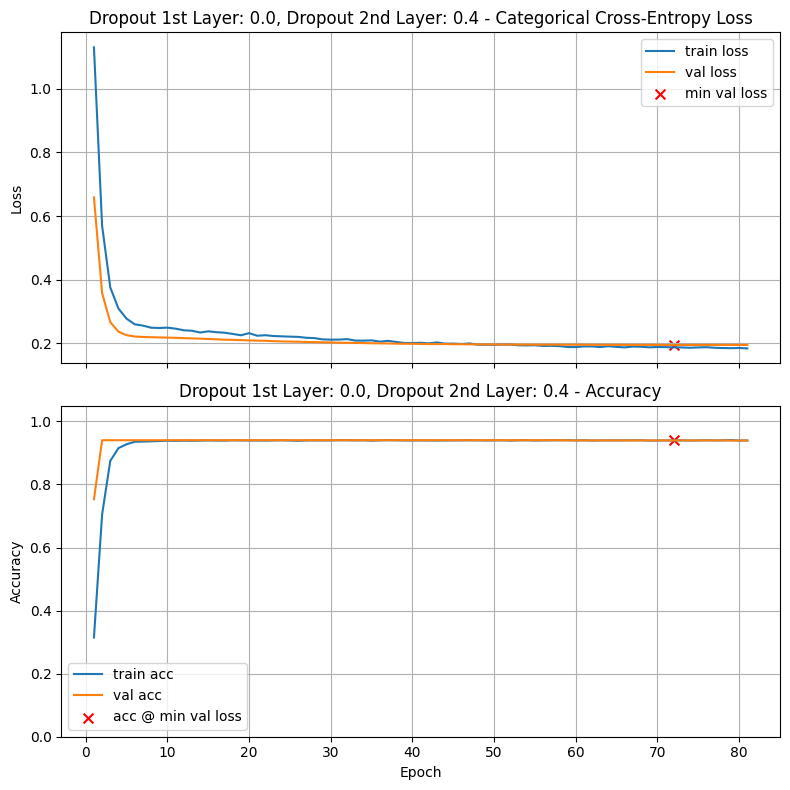

Final Training Loss:            0.1844
Final Training Accuracy:        0.9394
Final Validation Loss:          0.1952
Final Validation Accuracy:      0.9394
Minimum Validation Loss:        0.1951 (Epoch 72)
Validation Accuracy @ Min Loss: 0.9397
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step


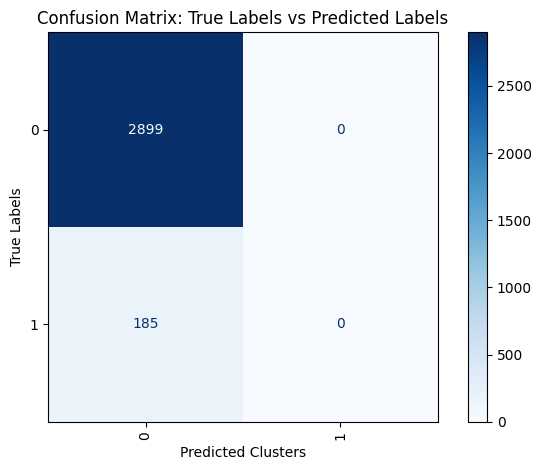


Test Loss: 0.1910
Test Accuracy: 0.9400

Validation-Test Gap (accuracy): 0.000324

Execution Time: 00:00:19

Dropout 1st Layer: 0.0, Dropout 2nd Layer: 0.5



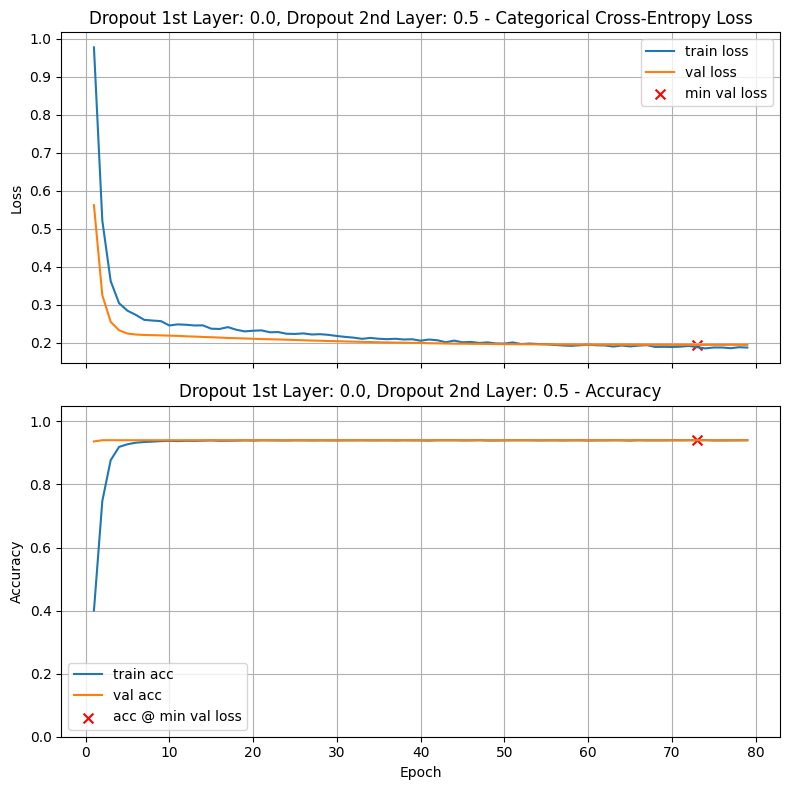

Final Training Loss:            0.1869
Final Training Accuracy:        0.9402
Final Validation Loss:          0.1941
Final Validation Accuracy:      0.9403
Minimum Validation Loss:        0.1938 (Epoch 73)
Validation Accuracy @ Min Loss: 0.9403
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step


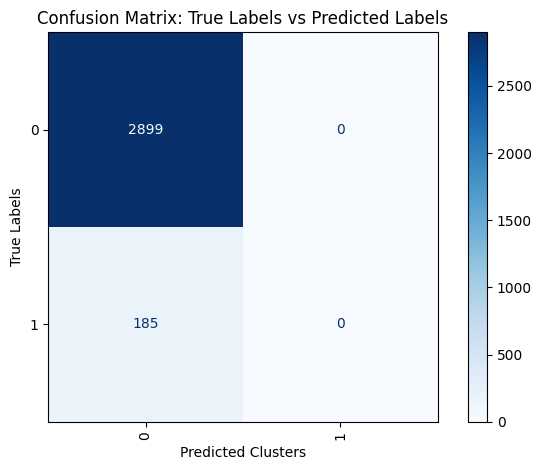


Test Loss: 0.1911
Test Accuracy: 0.9400

Validation-Test Gap (accuracy): 0.000324

Execution Time: 00:00:18

Dropout 1st Layer: 0.1, Dropout 2nd Layer: 0.3



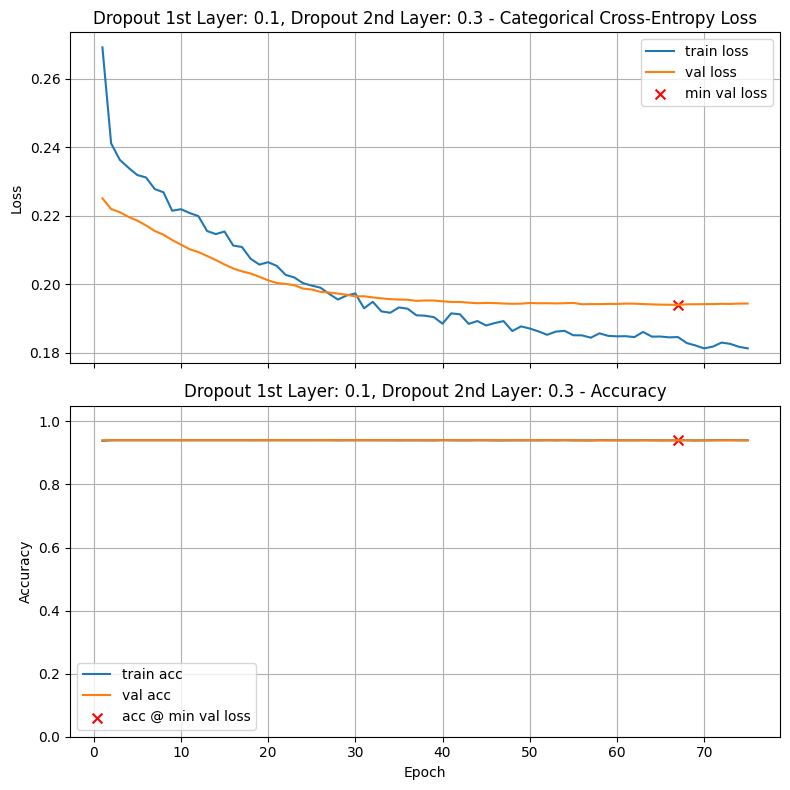

Final Training Loss:            0.1813
Final Training Accuracy:        0.9400
Final Validation Loss:          0.1944
Final Validation Accuracy:      0.9400
Minimum Validation Loss:        0.1940 (Epoch 67)
Validation Accuracy @ Min Loss: 0.9400
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step


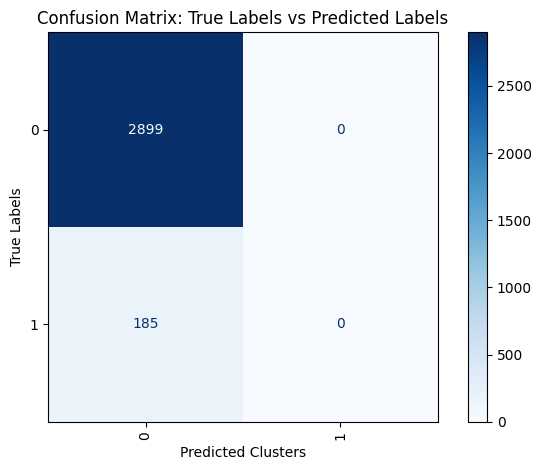


Test Loss: 0.1911
Test Accuracy: 0.9400

Validation-Test Gap (accuracy): 0.000000

Execution Time: 00:00:18

Dropout 1st Layer: 0.1, Dropout 2nd Layer: 0.4



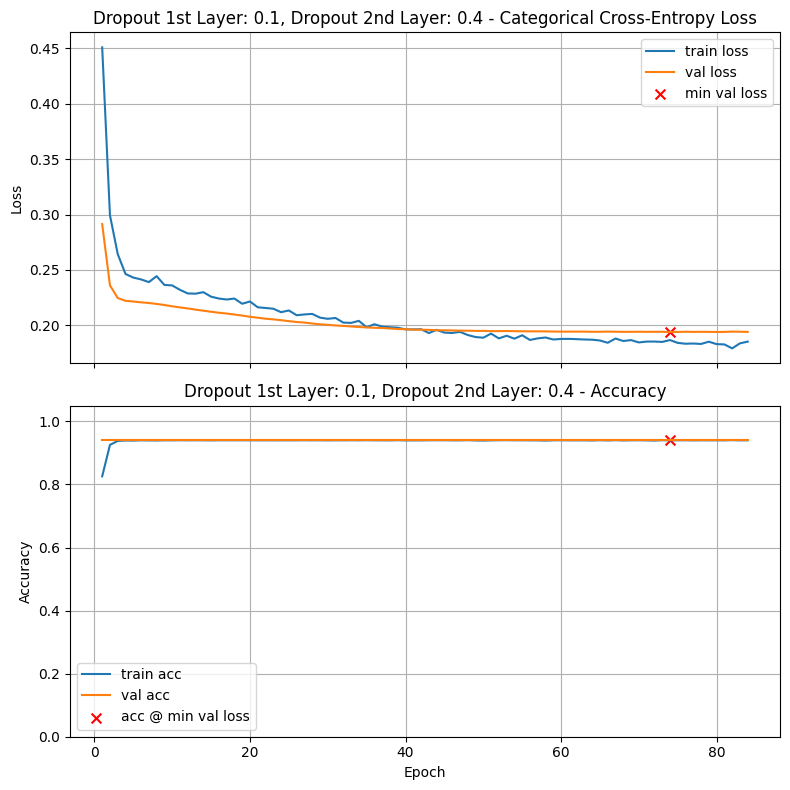

Final Training Loss:            0.1854
Final Training Accuracy:        0.9400
Final Validation Loss:          0.1942
Final Validation Accuracy:      0.9403
Minimum Validation Loss:        0.1941 (Epoch 74)
Validation Accuracy @ Min Loss: 0.9403
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step


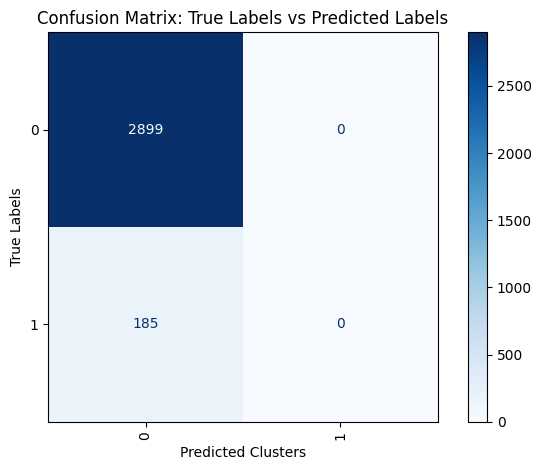


Test Loss: 0.1913
Test Accuracy: 0.9400

Validation-Test Gap (accuracy): 0.000324

Execution Time: 00:00:20

Dropout 1st Layer: 0.1, Dropout 2nd Layer: 0.5



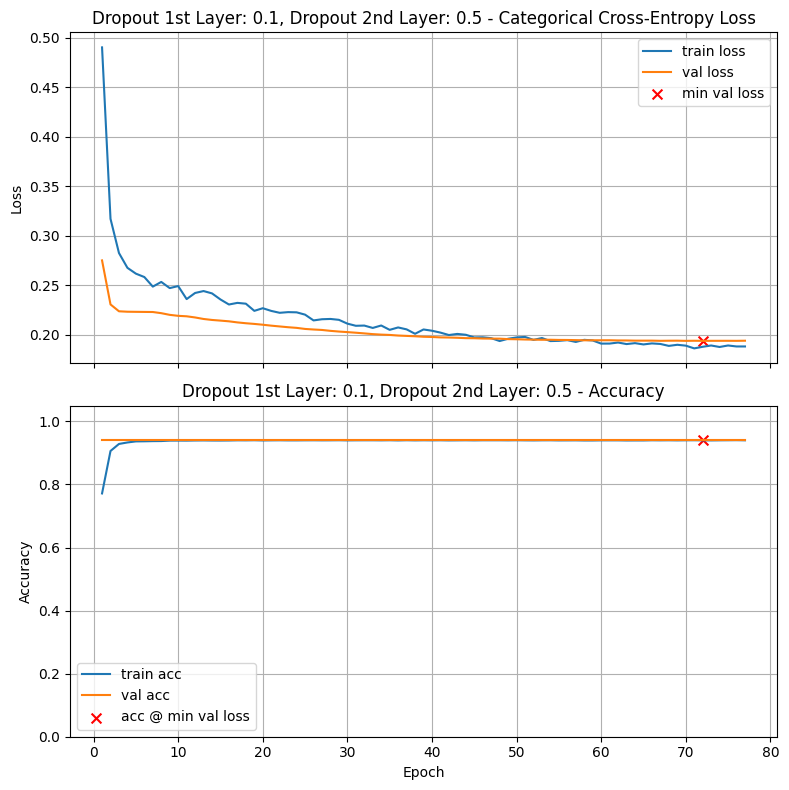

Final Training Loss:            0.1881
Final Training Accuracy:        0.9400
Final Validation Loss:          0.1939
Final Validation Accuracy:      0.9403
Minimum Validation Loss:        0.1938 (Epoch 72)
Validation Accuracy @ Min Loss: 0.9403
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step


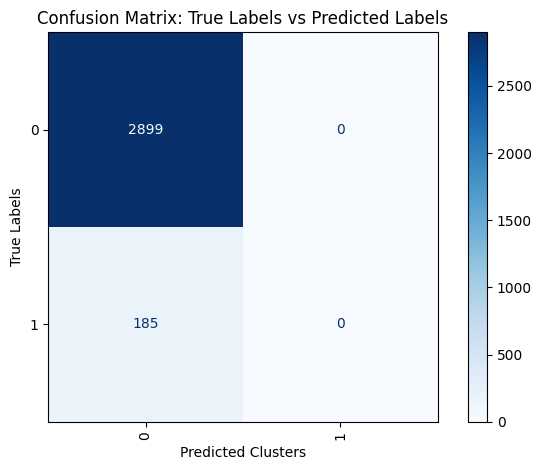


Test Loss: 0.1915
Test Accuracy: 0.9400

Validation-Test Gap (accuracy): 0.000324

Execution Time: 00:00:18

Dropout 1st Layer: 0.2, Dropout 2nd Layer: 0.3



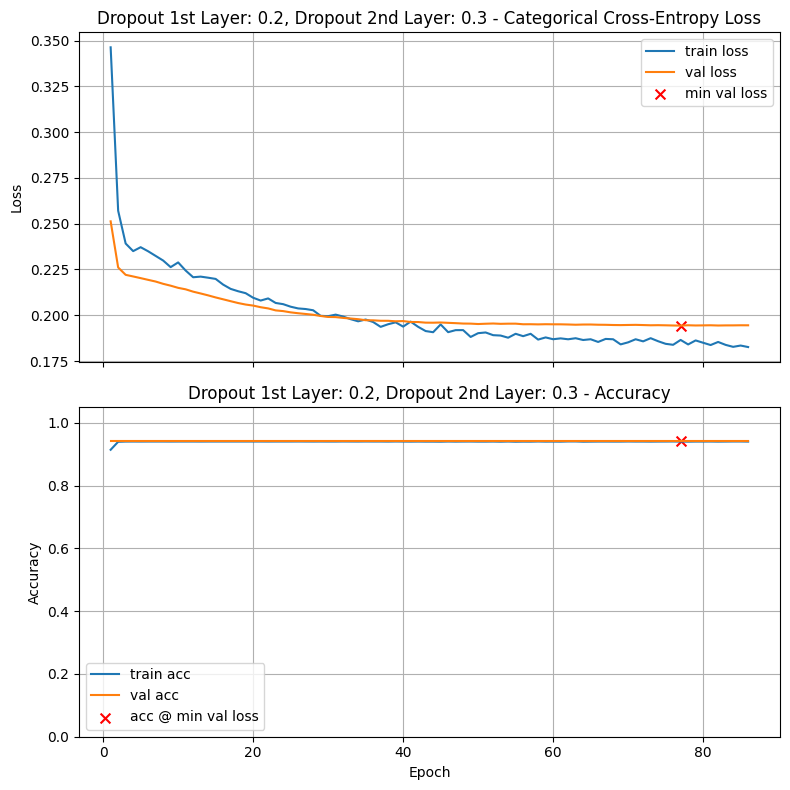

Final Training Loss:            0.1826
Final Training Accuracy:        0.9399
Final Validation Loss:          0.1945
Final Validation Accuracy:      0.9403
Minimum Validation Loss:        0.1943 (Epoch 77)
Validation Accuracy @ Min Loss: 0.9403
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step


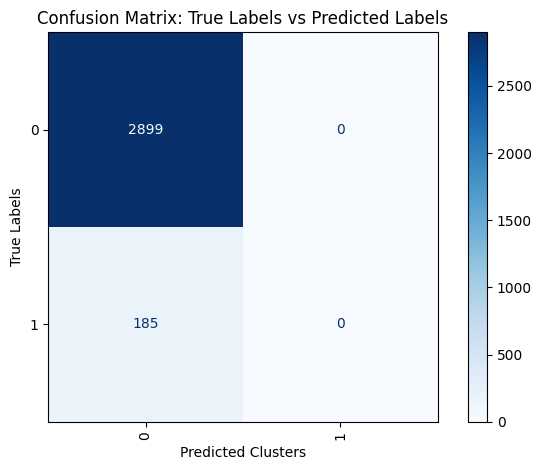


Test Loss: 0.1909
Test Accuracy: 0.9400

Validation-Test Gap (accuracy): 0.000324

Execution Time: 00:00:20

Dropout 1st Layer: 0.2, Dropout 2nd Layer: 0.4



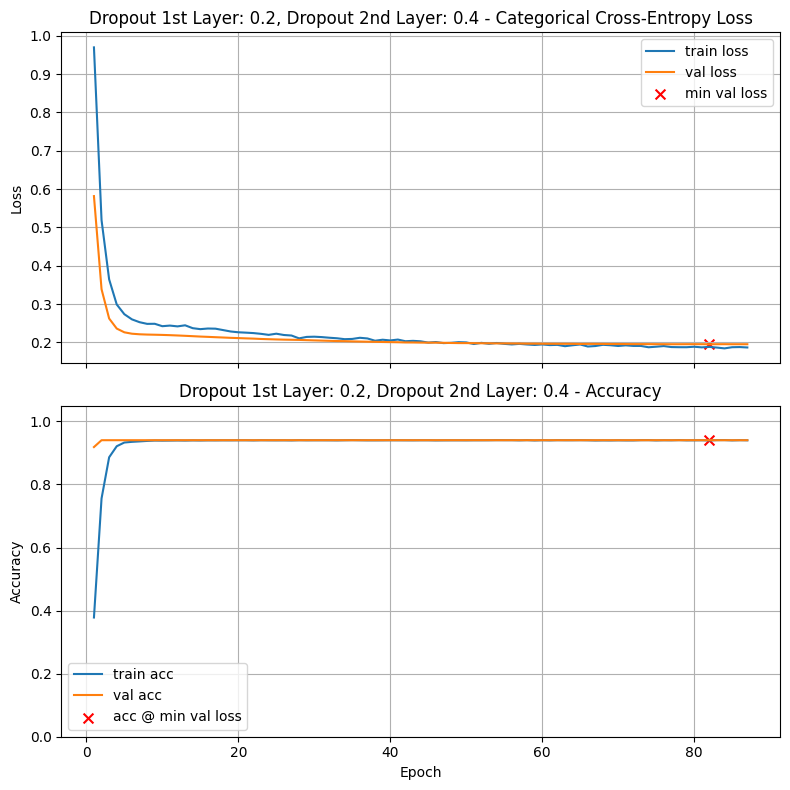

Final Training Loss:            0.1866
Final Training Accuracy:        0.9400
Final Validation Loss:          0.1951
Final Validation Accuracy:      0.9403
Minimum Validation Loss:        0.1950 (Epoch 82)
Validation Accuracy @ Min Loss: 0.9403
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step


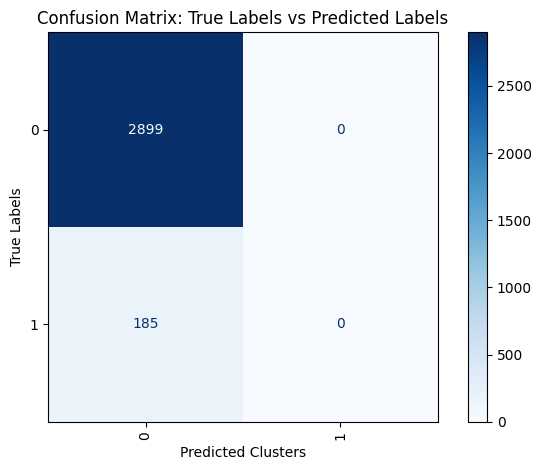


Test Loss: 0.1910
Test Accuracy: 0.9400

Validation-Test Gap (accuracy): 0.000324

Execution Time: 00:00:20

Dropout 1st Layer: 0.2, Dropout 2nd Layer: 0.5



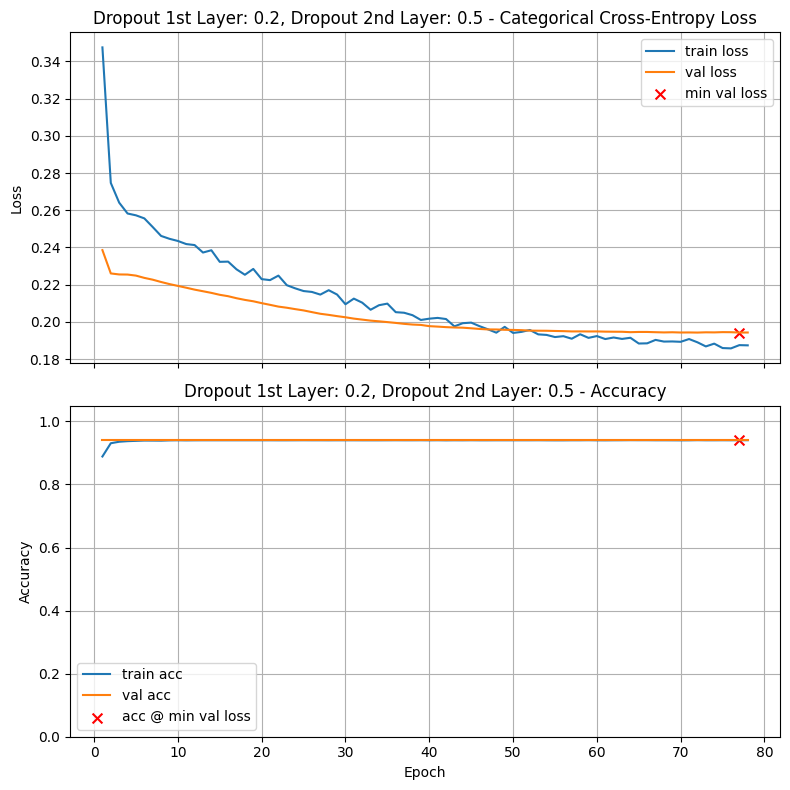

Final Training Loss:            0.1874
Final Training Accuracy:        0.9403
Final Validation Loss:          0.1943
Final Validation Accuracy:      0.9403
Minimum Validation Loss:        0.1943 (Epoch 77)
Validation Accuracy @ Min Loss: 0.9403
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step


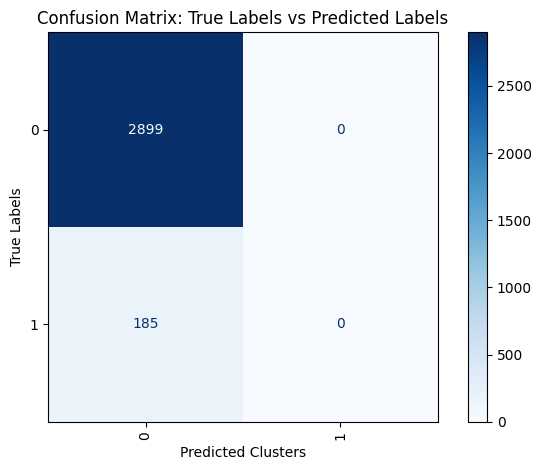


Test Loss: 0.1908
Test Accuracy: 0.9400

Validation-Test Gap (accuracy): 0.000324

Execution Time: 00:00:18


In [14]:
# Your code here. Add as many cells as you need.
lr = 1e-4

drop_out_1st_layer = [0.0, 0.1, 0.2]
drop_out_2nd_layer = [0.3, 0.4, 0.5]

results_3 = pd.DataFrame(columns=['First Dropout', 'Second Dropout', 'Best Val Accuracy', 'Min Val Loss'], index=[0,1,2,3,4,5,6,7,8])

for i, drop_out_1st in enumerate(drop_out_1st_layer):
    for j, drop_out_2nd in enumerate(drop_out_2nd_layer):
        model = build_model(X_train.shape[1], [ (64, af, 0.0, drop_out_1st), (32, af , 0.0, drop_out_2nd)], n_classes)
        history, metrics = train_and_test(model, lr_schedule=lr, title=f"Dropout 1st Layer: {drop_out_1st}, Dropout 2nd Layer: {drop_out_2nd}", verbose=0, return_history = True)
        results_3.iloc[i * 3 + j] = [drop_out_1st, drop_out_2nd, metrics['val_acc_at_min_loss'], metrics['min_val_loss']]

In [15]:
results_3

,First Dropout,Second Dropout,Best Val Accuracy,Min Val Loss
0,0.0,0.3,0.939689,0.194618
1,0.0,0.4,0.939689,0.195146
2,0.0,0.5,0.940337,0.193814
3,0.1,0.3,0.940013,0.193988
4,0.1,0.4,0.940337,0.194089
5,0.1,0.5,0.940337,0.193776
6,0.2,0.3,0.940337,0.194337
7,0.2,0.4,0.940337,0.195012
8,0.2,0.5,0.940337,0.194269
